In [4]:
import numpy as np
import math
from tensorflow.keras import initializers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [5]:
def plot_confusion_mtx(matrix,num_classes):

  plt.figure(figsize=(10,8))
  ax= plt.subplot()
  cmap=sns.light_palette("blue")
  sns.heatmap(matrix, annot=True, ax = ax,fmt=".3f"); 
  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels([str(i) for i in range(num_classes)]); ax.yaxis.set_ticklabels([str(i) for i in range(num_classes)]);
  plt.show()

In [6]:
from keras.datasets import fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
labels=["T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

4423680/4422102 [==============================] - 0s 0us/step


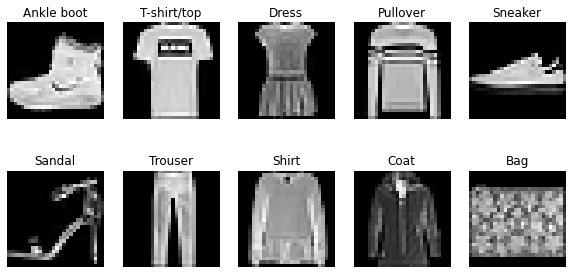

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5)) 

plottedClass =  [False for i in range(10)] 
count=0
for i in range(25):
    if  plottedClass[Y_train[i]]==False:
      plt.subplot(2,5,count+1).set_title(labels[Y_train[i]]) 
      plt.imshow(X_train[i],cmap='gray')
      plt.axis("off")
      plottedClass[Y_train[i]]=True
      count=count+1

plt.show()

**Backpropagation code stage1.**

In [8]:
#flatten the Xtrain and X_test
X_train=X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test=X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

#create one hot encoding of the labels
Y_train_ohe=OneHotEncoder().fit_transform(Y_train.reshape(-1,1)).toarray()
Y_test_ohe=OneHotEncoder().fit_transform(Y_test.reshape(-1,1)).toarray()


#normalizing the train data and test data...
X_train=X_train/255
X_test=X_test/255

In [9]:
class Activation:

  def Sigmoid(self,x):
    return 1/(1+np.exp(-x))

  def Softmax(self,x):
    mx=np.max(x)
    numr=np.exp(x-mx)
    return numr/(np.sum(numr))

  #to restrict the output of re
  def Relu(self,x):
    li=[]
    for i in x:
      if i < 0:
        li.append(0)
      else:
        li.append(min(i,6))
    return np.array(li)

  def Tanh(self,x):
    numr=np.exp(x)-np.exp(-x)
    denom=np.exp(x)+np.exp(-x)
    return numr/denom

  def Derivative_Sigmoid(self,x):
    s=1/(1+np.exp(-x))
    return s*(1-s)

  def Derivative_Relu(self,x):
    return x>=0

  def Derivative_Tanh(self,x):
    return 1-self.Tanh(x)**2

  def Linear(self,x):
    return x


In [10]:
class Loss:

  #Takes ypred as [[],[]] and y as [[],[]]
  def CategoricalCrossEntropy(self,ypred,y):
    
    class_idx=np.argmax(y,axis=1)
    cce_loss=0
    for i in range(len(class_idx)):
      cce_loss+=(-1)*np.log2(ypred[i][class_idx[i]])

    return cce_loss/len(ypred)


  def meansquarederror(self,ypred,y):

    #check for correct squared loss function
    return np.sum((ypred-y)**2)/len(ypred)



In [11]:
class Layer:

  def __init__(self,num_inputs,num_neurons,activation,optimizer,layerInitialization):
    
    self.num_inputs=num_inputs
    self.num_neurons=num_neurons
    self.activation=activation
    self.optimizer=optimizer
    if layerInitialization=="Random":
      self.W=np.random.randn(self.num_neurons,self.num_inputs)
      self.b=np.random.randn(self.num_neurons,)
    elif layerInitialization=="Xavier":
      initializer = tf.keras.initializers.Xavier()
      self.W=initializer(self.num_neurons,self.num_inputs)
      self.b=initializer(self.num_neurons,)

    self.aL=0
    self.hL=0
    self.del_h=0
    self.del_a=0
    self.delW=0
    self.delb=0

    #prev params for Moment based annd nestrov
    self.prev_Uw=0
    self.prev_Ub=0

    #vt for Rmsprop
    self.prev_Vw=0
    self.prev_Vb=0

    #mt for Adam.
    self.prev_Mw=0
    self.prev_Mb=0
  

  def Forward(self,h_L_1):
    
    self.aL=np.dot(self.W,h_L_1)+self.b

    if self.activation=="Relu":
      self.hL=Activation().Relu(self.aL)

    elif self.activation=="Tanh":
      self.hL=Activation().Tanh(self.aL)
    
    elif self.activation=="Softmax":
      self.hL=Activation().Softmax(self.aL)
    
    elif self.activation=="Linear":
      self.hL=Activation().Linear(self.aL)

    elif self.activation == 'Sigmoid':
      self.hL=Activation().Sigmoid(self.aL)
    
    else:
      raise Exception("choose a valid activation from {'Sigmoid','Tanh','Relu','Softmax','Linear'}")

    
  def get_gradients(self,isoplayer,Y_hat,Y,prev_hL,nextW,next_del_a):
      
      #If it is the output layer...
      if isoplayer==1:

        if self.activation=='Softmax':
          for i in range(len(Y_hat)):
            self.del_h+=((-1/(Y_hat[i][np.argmax(Y[i])]))*Y[i])
          
          self.del_h/=len(Y)
          
          for i in range(len(Y_hat)):  
            self.del_a+=(Y_hat[i]-Y[i])
          
          self.del_a/=len(Y)
      
      #write the gradients formula for linear activation...
        elif self.activation == 'Linear':
          for i in range(len(Y_hat)):
            self.del_h+=2*(Y_hat[i] - Y[i])
          
          self.del_h/=len(Y)

          self.del_a = self.del_h

        
        else:
          raise Exception("!!! The activation passed is not yet Implemented...")

      #if it is not the output layer..
      else:
        self.del_h = np.dot((nextW).T,next_del_a)

        #gradients wrt pre activation for different Activation function used..
        if self.activation=="Relu":
          self.del_a=(self.del_h)*(Activation().Derivative_Relu(self.aL))

        elif self.activation=="Tanh":
          self.del_a=(self.del_h)*(Activation().Derivative_Tanh(self.aL))
      
        else:
          self.del_a=(self.del_h)*(Activation().Derivative_Sigmoid(self.aL))


      
      self.delW=np.dot(self.del_a.reshape(-1,1),prev_hL.reshape(1,-1))
      self.delb=self.del_a

    
  def reset_gradients(self):
    
    self.del_h=0
    self.del_a=0
    self.delW=0
    self.delb=0

  

In [12]:
class IpLayer:

  def __init__(self,num_neurons):
    self.num_neurons=num_neurons
    self.hL=0

  def Forward(self,x):
    self.hL=x


In [37]:
class NN:

  def __init__(self,input_shape,num_hlayers,neurons,hiddenLayerActivation,outputActivation,optimizer,learningrate,batch_size,epochs,layerInitialization,output_shape):

    self.input_shape=input_shape
    self.output_shape=output_shape
    self.num_hlayers=num_hlayers
    self.neurons=neurons
    self.HLAc=hiddenLayerActivation
    self.OPAc=outputActivation
    self.optimizer=optimizer
    self.batch_size=batch_size
    self.epochs=epochs
    
    self.Layers=[]
    self.eta=learningrate

    #variables for different optimizers
    self.gamma=learningrate
    self.beta=0.8
    self.epsilon=1e-5
    self.beta1=0.9
    self.beta2=0.999
    
    #create input layer
    self.Layers.append(IpLayer(self.input_shape))

    #hidden layers..
    for layer in range(1,self.num_hlayers+2):
      
      ip_shape=self.Layers[layer-1].num_neurons

      #output layer...
      if layer==self.num_hlayers+1:
         self.Layers.append(Layer(ip_shape,self.output_shape,self.OPAc,self.optimizer,layerInitialization))
      
      else:
        self.Layers.append(Layer(ip_shape,self.neurons[layer-1],self.HLAc,self.optimizer,layerInitialization))
  
  
  def Do_one_Pass(self,X,Y,iteration):
    
    Y_hat=[]

    if self.optimizer=='Nestrov' or self.optimizer=='Nadam':
      #Get look aheads Wla and bla for each layer...
      for i in range(1,self.num_hlayers+2):
        self.Layers[i].W = self.Layers[i].W - self.gamma * self.Layers[i].prev_Uw
        self.Layers[i].b = self.Layers[i].b - self.gamma * self.Layers[i].prev_Ub

     
    #1.Do feed forward... and get Y_hat...
    for i in range(X.shape[0]):
      #get the data in input layer
      self.Layers[0].Forward(X[i])
      #pass the data to the hl+ol
      for j in range(1,self.num_hlayers+2):
        h_L_1=self.Layers[j-1].hL
        self.Layers[j].Forward(h_L_1)

      ypred=self.Layers[self.num_hlayers+1].hL
      Y_hat.append(ypred)
      
    #2 Do back propogation...
    for i in range(self.num_hlayers+1,0,-1):
      prev_hL=self.Layers[i-1].hL
      if i==self.num_hlayers+1:
        self.Layers[i].get_gradients(1,Y_hat,Y,prev_hL,0,0)
      else:
        next_W=self.Layers[i+1].W
        next_del_a=self.Layers[i+1].del_a
        self.Layers[i].get_gradients(0,Y_hat,Y,prev_hL,next_W,next_del_a)
      
      
    #3.Update parameters for each layer...
    for i in range(1,self.num_hlayers+2):

      if self.optimizer == 'Simple_GD':
        self.Layers[i].W = self.Layers[i].W - (self.eta)*(self.Layers[i].delW)
        self.Layers[i].b = self.Layers[i].b - (self.eta)*(self.Layers[i].delb)

      elif self.optimizer == 'Moment_Based' or self.optimizer == 'Nestrov':

        #get momentum..
        Uw_t = (self.gamma) * (self.Layers[i].prev_Uw) + (self.eta) * (self.Layers[i].delW)
        Ub_t = self.gamma * self.Layers[i].prev_Ub + (self.eta) * (self.Layers[i].delb)

        #update the parameters..
        self.Layers[i].W = self.Layers[i].W - Uw_t
        self.Layers[i].b = self.Layers[i].b - Ub_t

        #update the moments..
        self.Layers[i].prev_Uw = Uw_t
        self.Layers[i].prev_Ub = Ub_t

      elif self.optimizer == 'RMSProp':

        #get vt's and update history..
        self.Layers[i].prev_Vw = (self.beta)*(self.Layers[i].prev_Vw) + (1-self.beta)*(self.Layers[i].delW)**2  
        self.Layers[i].prev_Vb = (self.beta)*(self.Layers[i].prev_Vb) + (1-self.beta)*(self.Layers[i].delb)**2   

        #update the parameters..
        self.Layers[i].W = self.Layers[i].W - (self.eta/np.sqrt(self.Layers[i].prev_Vw+self.epsilon)* (self.Layers[i].delW))
        self.Layers[i].b = self.Layers[i].b - (self.eta/np.sqrt(self.Layers[i].prev_Vb+self.epsilon)* (self.Layers[i].delb))


      elif self.optimizer == 'Adam' or self.optimizer == 'Nadam':

        #1>> Get the moment update: M_w=beta1*prev_Mw+(1-beta1)*(delW) and  M_b=beta1*prev_Mb+(1-beta1)*(delb)
        #update previous history..
        self.Layers[i].prev_Mw = self.beta1 * self.Layers[i].prev_Mw + (1-self.beta1) * (self.Layers[i].delW)
        self.Layers[i].prev_Mb = self.beta1 * self.Layers[i].prev_Mb + (1-self.beta1) * (self.Layers[i].delb)

        
        #2>> Get the learning rate update: Vw=beta2*(V_w[t-1])+(1-beta2)*(delW)**2
        self.Layers[i].prev_Vw = self.beta2 * self.Layers[i].prev_Vw + (1-self.beta2) * (self.Layers[i].delW)**2
        self.Layers[i].prev_Vb = self.beta2 * self.Layers[i].prev_Vb + (1-self.beta2) * (self.Layers[i].delb)**2

        #3>> Get m^W,V^W and m^b and V^b
        m_w_hat = self.Layers[i].prev_Mw/(1 - math.pow(self.beta1,iteration+1))
        m_b_hat = self.Layers[i].prev_Mb/(1-math.pow(self.beta1,iteration+1))

        v_w_hat = self.Layers[i].prev_Vw/(1-math.pow(self.beta2,iteration+1))
        v_b_hat = self.Layers[i].prev_Vb/(1-math.pow(self.beta2,iteration+1))

        #4>> update W ,b for each layer..
        self.Layers[i].W = self.Layers[i].W - (self.eta/np.sqrt(v_w_hat+self.epsilon))*m_w_hat
        self.Layers[i].b = self.Layers[i].b - (self.eta/np.sqrt(v_b_hat+self.epsilon))*m_b_hat

      
      else:
        raise Exception("Invalid optimizer!!!!! use from the following list =['Simple_GD','Moment_Based','Nestrov','RMSProp','Adam','Nadam']")


        
    #4.reset the gradients...
    for i in range(1,self.num_hlayers+2):
      self.Layers[i].reset_gradients()
    

  #takes complete X_train and Y_train and return the (n x 10) probability distribution.
  def Final_Prediction(self,X):
    pred_whole=[]

    for i in range(X.shape[0]):
      #get the data in input layer
      self.Layers[0].Forward(X[i])
      #pass the data to the hl+ol
      for j in range(1,self.num_hlayers+2):
        h_L_1=self.Layers[j-1].hL
        self.Layers[j].Forward(h_L_1)

      ypred=self.Layers[self.num_hlayers+1].hL
      pred_whole.append(ypred)   

    return pred_whole  
 

**Training..**

In [38]:
def MINI_BATCH(NN,X,Y):
  loss_epoch=[]
  n=X.shape[0]
  for i in range(NN.epochs):
    itr=0
    sidx = 0
    while sidx+batch_size <= n:
      NN.Do_one_Pass(X[sidx:sidx+batch_size],Y[sidx:sidx+batch_size],itr)
      itr+=1
      sidx+=batch_size
    
    #pass the remining data.
    if sidx!=n:
      NN.Do_one_Pass(X[sidx:n],Y[sidx:n],itr)

    #loss for this epoch..
    ypred = NN.Final_Prediction(X)
    if NN.OPAc == 'Linear':
      loss_epoch.append(Loss().meansquarederror(ypred,Y))
    else:
      loss_epoch.append(Loss().CategoricalCrossEntropy(ypred,Y))
      
      
    if i==epochs-1:
      return (ypred,loss_epoch)


**Testing for linear activation**

train accuracy
0.0


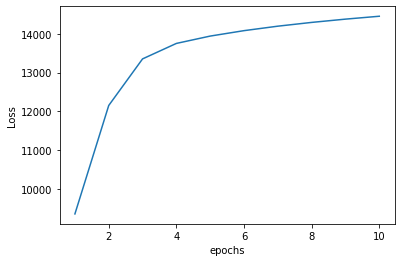

test accuracy
0.0


In [35]:
Y_sample=Y_train[:1000]

NN1 = NN(input_shape=784,num_hlayers=2,neurons=[32,16],hiddenLayerActivation='Sigmoid',outputActivation='Linear',optimizer='Nestrov',\
         learningrate=1e-3,batch_size=1,layerInitialization='Random',output_shape=1)

pred , loss=MINI_BATCH(NN1,X_sample,Y_sample,1,epochs)
print("train accuracy")
print(np.sum(np.max(pred,axis=1)==Y_sample)/len(Y_sample))

plt.plot(np.arange(1,epochs+1),loss)
plt.xlabel("epochs");plt.ylabel("Loss");plt.show()

print("test accuracy")
predtest=NN1.Final_Prediction(X_test)
print(np.sum(np.max(predtest,axis=1)==Y_test)/len(Y_test))



In [41]:
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 2.0MB 7.3MB/s 
     |████████████████████████████████| 133kB 39.0MB/s 
     |████████████████████████████████| 102kB 8.6MB/s 
     |████████████████████████████████| 163kB 41.6MB/s 
     |████████████████████████████████| 71kB 5.8MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [42]:
sweep_config = {
  "name": "My Sweep",
  "method": "bayes",
  "metric": {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
  "parameters": {
        "optimizer": {
            "values": ["Simple_GD","Moment_Based","Adam","Nestrov","Nadam"]
        },
        "neurons":{
            "values":[32, 64, 128]
        },
        "num_hlayers":{
            "values":[1]
        },
        "hiddenLayerActivation":{
            "values":['Sigmoid','Relu','Tanh','Softmax','Linear']
        },
        "outputActivation":{
            "values":['Softmax','Linear']
        },
        "learningrate":{
            "values":[1e-3,1e-4]
        },
        "layerInitialization":{
            "values":['Random','Xavier']
        },
        "epochs":{
            "values":[5,10,20]
        },
        "batch_size":{
            "values":[1,32,1000]
        }

    }
}

sweep_id = wandb.sweep(sweep_config, project='DeepLearning', entity='abhisheknegi_cs20m008')

Create sweep with ID: 9x5le5kg
Sweep URL: https://wandb.ai/abhisheknegi_cs20m008/DeepLearning/sweeps/9x5le5kg


wandb: Agent Starting Run: haojnxy1 with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Softmax
wandb: Currently logged in as: abhisheknegi_cs20m008 (use `wandb login --relogin` to force relogin)


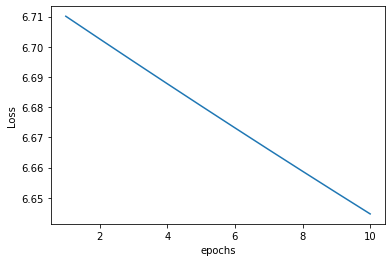

Train accuracy,0.105
_runtime,6
_timestamp,1615543553
_step,1
Test accuracy,0.0995


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: bn207ct4 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Tanh
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Linear


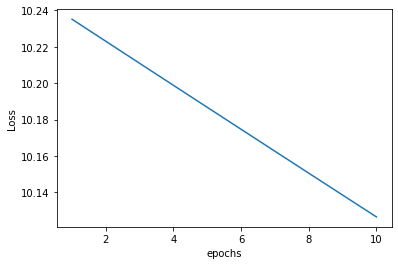

Train accuracy,0.104
_runtime,6
_timestamp,1615543565
_step,1
Test accuracy,0.1


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: amqanxo2 with config:
wandb: 	batch_size: 1
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Linear
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Softmax


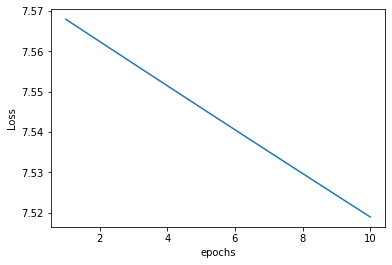

Train accuracy,0.104
_runtime,7
_timestamp,1615543580
_step,1
Test accuracy,0.1002


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: cpyjqdxn with config:
wandb: 	batch_size: 1
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Linear


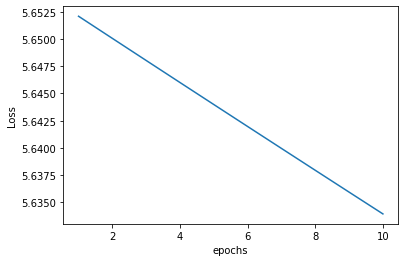

Train accuracy,0.108
_runtime,6
_timestamp,1615543594
_step,1
Test accuracy,0.1102


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: tkwvtwsh with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Linear
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Softmax


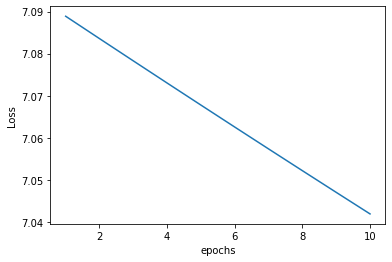

Train accuracy,0.09
_runtime,6
_timestamp,1615543609
_step,1
Test accuracy,0.0975


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: izfp2ixq with config:
wandb: 	batch_size: 1
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Linear


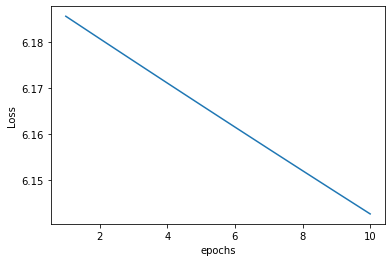

Train accuracy,0.112
_runtime,7
_timestamp,1615543626
_step,1
Test accuracy,0.1016


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: cqjjzqx3 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Softmax


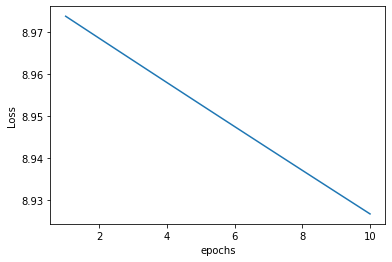

Train accuracy,0.09
_runtime,7
_timestamp,1615543642
_step,1
Test accuracy,0.0818


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 4gjf5fqw with config:
wandb: 	batch_size: 1
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Linear


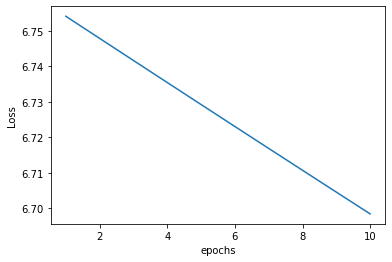

Train accuracy,0.112
_runtime,6
_timestamp,1615543658
_step,1
Test accuracy,0.0997


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: k2km226y with config:
wandb: 	batch_size: 1
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax


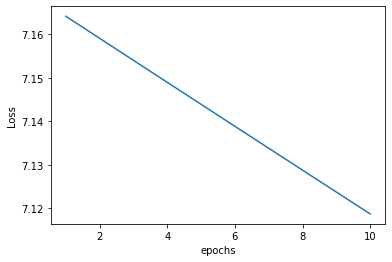

Train accuracy,0.067
_runtime,7
_timestamp,1615543675
_step,1
Test accuracy,0.0668


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: itx9izqy with config:
wandb: 	batch_size: 1
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Softmax


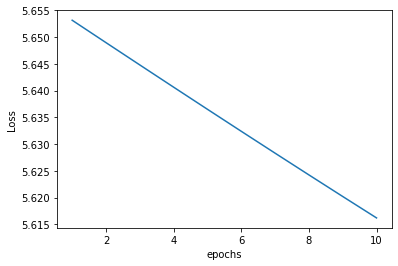

Train accuracy,0.102
_runtime,6
_timestamp,1615543691
_step,1
Test accuracy,0.0989


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: xznw4hxa with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Linear
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax


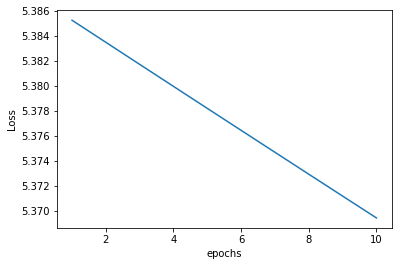

Train accuracy,0.057
_runtime,7
_timestamp,1615543708
_step,1
Test accuracy,0.0589


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: z7nht0br with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Linear


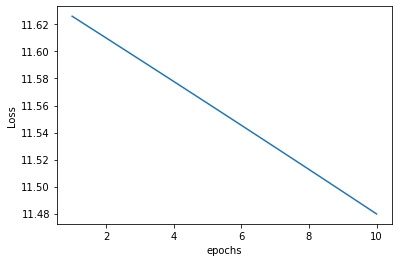

Train accuracy,0.093
_runtime,6
_timestamp,1615543725
_step,1
Test accuracy,0.1001


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: cdirym6x with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Linear


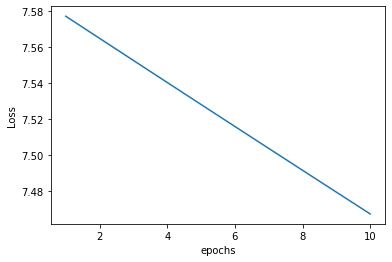

Train accuracy,0.104
_runtime,6
_timestamp,1615543742
_step,1
Test accuracy,0.1


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: o4f0bivh with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Linear


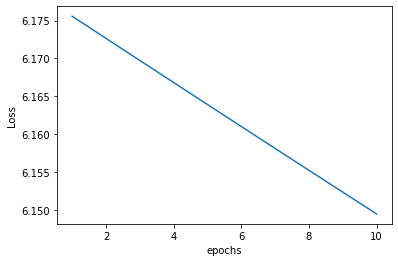

Train accuracy,0.157
_runtime,6
_timestamp,1615543760
_step,1
Test accuracy,0.1564


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: li23sl6o with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Linear


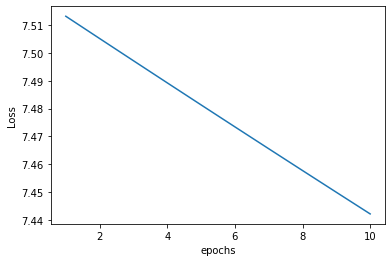

Train accuracy,0.1
_runtime,6
_timestamp,1615543777
_step,1
Test accuracy,0.1059


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: xm1u409e with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Softmax


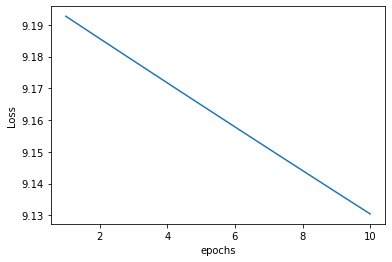

Train accuracy,0.098
_runtime,7
_timestamp,1615543795
_step,1
Test accuracy,0.0978


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 4u47o4a4 with config:
wandb: 	batch_size: 1
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Linear


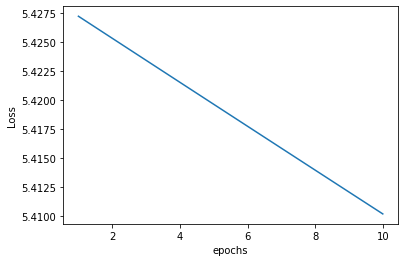

Train accuracy,0.123
_runtime,7
_timestamp,1615543813
_step,1
Test accuracy,0.1189


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: wofx10lb with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Linear


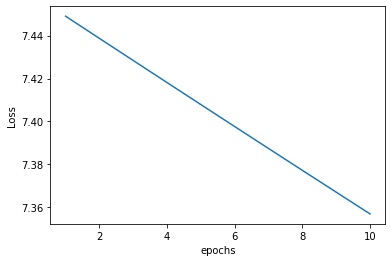

Train accuracy,0.1
_runtime,7
_timestamp,1615543832
_step,1
Test accuracy,0.1


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: estiiqnb with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Softmax


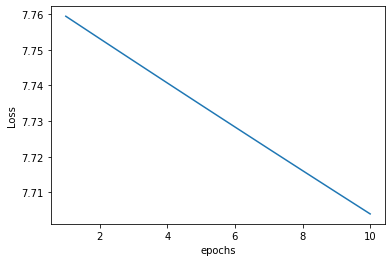

Train accuracy,0.093
_runtime,7
_timestamp,1615543849
_step,1
Test accuracy,0.0944


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 3syv19lp with config:
wandb: 	batch_size: 1
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Tanh
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax


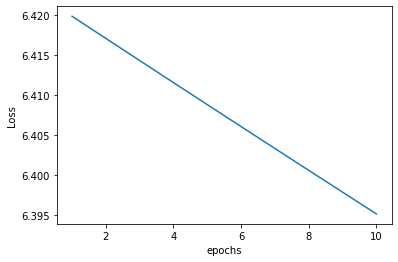

Train accuracy,0.114
_runtime,7
_timestamp,1615543867
_step,1
Test accuracy,0.1096


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: p7vglyi1 with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Linear
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Softmax


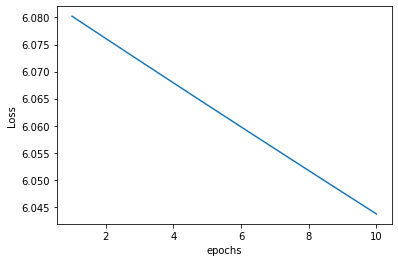

Train accuracy,0.089
_runtime,7
_timestamp,1615543886
_step,1
Test accuracy,0.081


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: wt4o3ztz with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Softmax


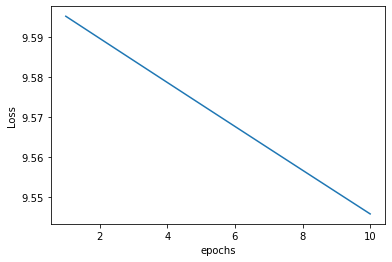

Train accuracy,0.072
_runtime,7
_timestamp,1615543904
_step,1
Test accuracy,0.0705


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: ij21exmx with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Linear


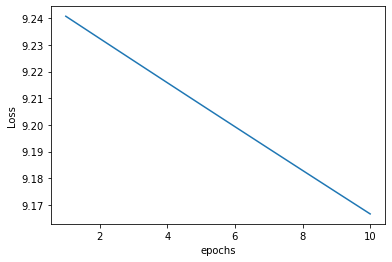

Train accuracy,0.094
_runtime,6
_timestamp,1615543922
_step,1
Test accuracy,0.0928


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: emf4njn9 with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Softmax


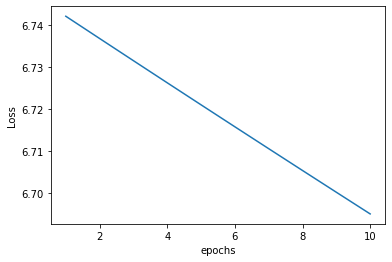

Train accuracy,0.092
_runtime,7
_timestamp,1615543940
_step,1
Test accuracy,0.1038


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5m225c3g with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Tanh
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax


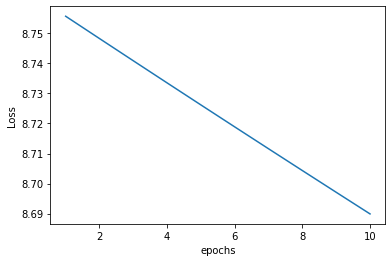

Train accuracy,0.116
_runtime,7
_timestamp,1615543966
_step,1
Test accuracy,0.1319


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: iugaxha5 with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Linear


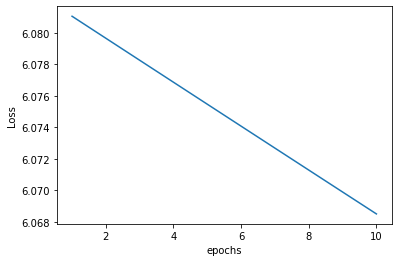

Train accuracy,0.052
_runtime,7
_timestamp,1615543985
_step,1
Test accuracy,0.0477


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: kin3ckp4 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax


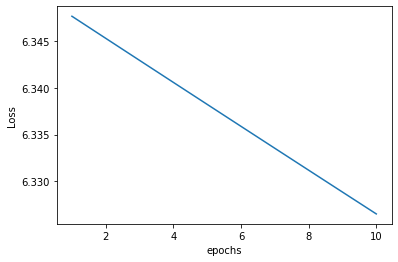

Train accuracy,0.136
_runtime,7
_timestamp,1615544003
_step,1
Test accuracy,0.1328


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: btcvqas2 with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Linear
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Softmax


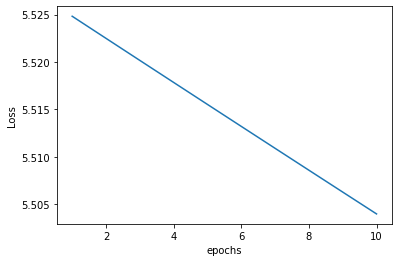

Train accuracy,0.092
_runtime,7
_timestamp,1615544022
_step,1
Test accuracy,0.0982


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: c9aowxk7 with config:
wandb: 	batch_size: 1
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Tanh
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Linear


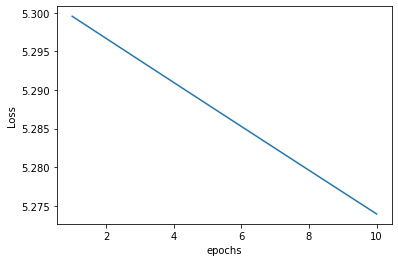

Train accuracy,0.113
_runtime,7
_timestamp,1615544040
_step,1
Test accuracy,0.1095


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: waf7mj22 with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax


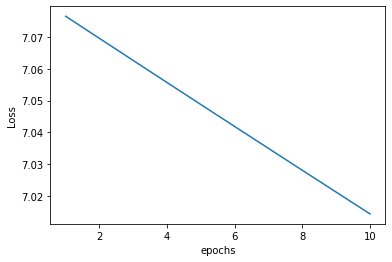

Train accuracy,0.122
_runtime,7
_timestamp,1615544059
_step,1
Test accuracy,0.1183


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 7pqf9sgq with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Linear


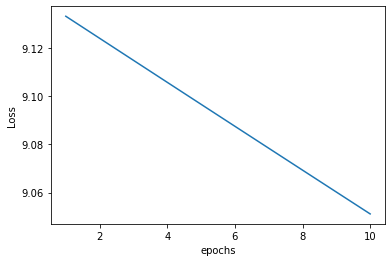

Train accuracy,0.099
_runtime,7
_timestamp,1615544077
_step,1
Test accuracy,0.1


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 3bofe6px with config:
wandb: 	batch_size: 1
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Linear


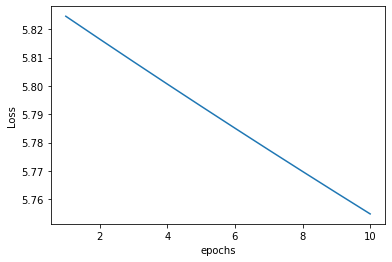

Train accuracy,0.115
_runtime,7
_timestamp,1615544097
_step,1
Test accuracy,0.1046


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: glmtzovy with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Softmax


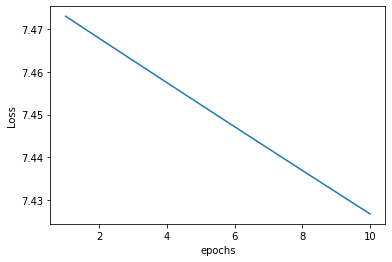

Train accuracy,0.097
_runtime,7
_timestamp,1615544115
_step,1
Test accuracy,0.0992


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 71mrdcc8 with config:
wandb: 	batch_size: 1
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Linear


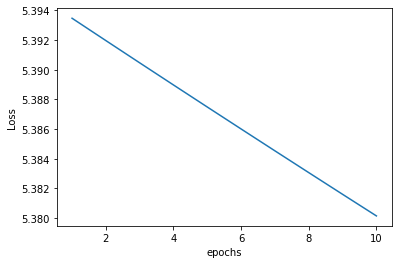

Train accuracy,0.072
_runtime,7
_timestamp,1615544134
_step,1
Test accuracy,0.0562


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 2lhxu2h3 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Softmax


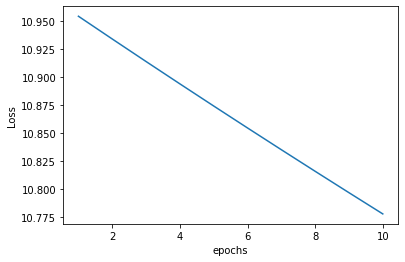

Train accuracy,0.107
_runtime,7
_timestamp,1615544154
_step,1
Test accuracy,0.1


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 6cxjuzrw with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Tanh
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Linear


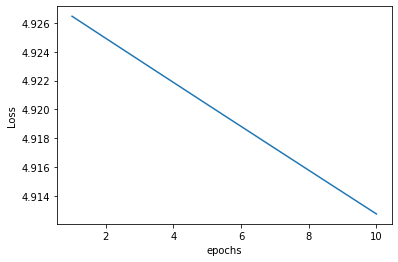

Train accuracy,0.068
_runtime,7
_timestamp,1615544172
_step,1
Test accuracy,0.0614


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: u5hhjtq7 with config:
wandb: 	batch_size: 1
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Linear


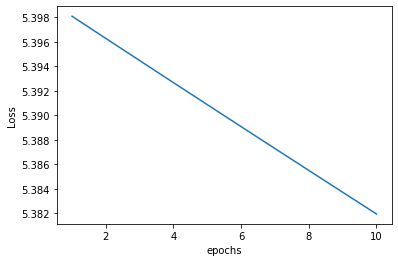

Train accuracy,0.086
_runtime,7
_timestamp,1615544192
_step,1
Test accuracy,0.0838


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: m6nnxsrz with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Softmax


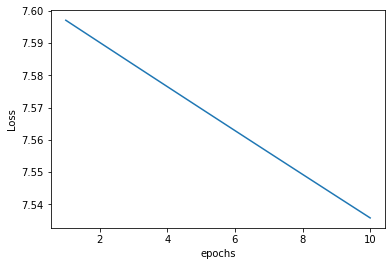

Train accuracy,0.086
_runtime,7
_timestamp,1615544211
_step,1
Test accuracy,0.1


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: iwpvcwge with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Linear
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Linear


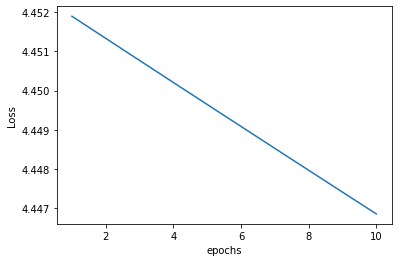

Train accuracy,0.009
_runtime,7
_timestamp,1615544230
_step,1
Test accuracy,0.0156


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: k4mc3vpr with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Softmax


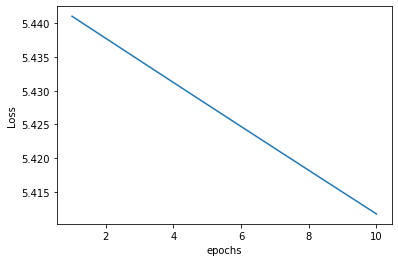

Train accuracy,0.105
_runtime,7
_timestamp,1615544249
_step,1
Test accuracy,0.0913


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: jc5hz3ov with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Linear


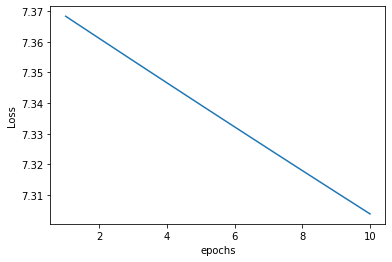

Train accuracy,0.1
_runtime,7
_timestamp,1615544267
_step,1
Test accuracy,0.1118


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: z3i71tah with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Linear
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Linear


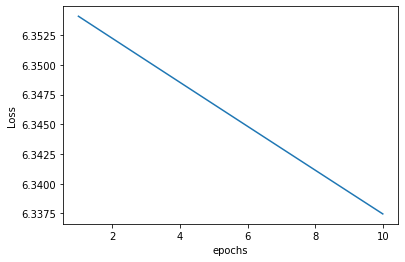

Train accuracy,0.048
_runtime,7
_timestamp,1615544285
_step,1
Test accuracy,0.0525


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: enl4x1mh with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax


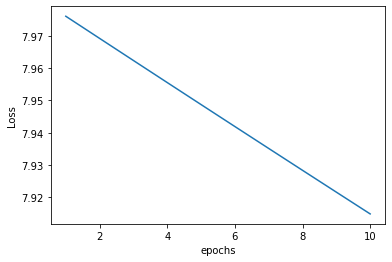

Train accuracy,0.099
_runtime,7
_timestamp,1615544304
_step,1
Test accuracy,0.1046


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: eywh3sco with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Softmax


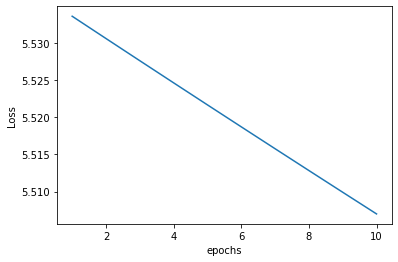

Train accuracy,0.127
_runtime,7
_timestamp,1615544323
_step,1
Test accuracy,0.115


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: p0hqore0 with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Softmax


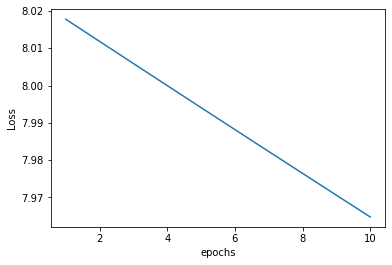

Train accuracy,0.117
_runtime,7
_timestamp,1615544343
_step,1
Test accuracy,0.0995


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: r9o5masa with config:
wandb: 	batch_size: 1
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Softmax


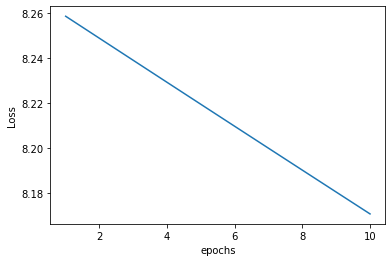

Train accuracy,0.115
_runtime,8
_timestamp,1615544362
_step,1
Test accuracy,0.1151


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 7lpivq4u with config:
wandb: 	batch_size: 1
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Linear


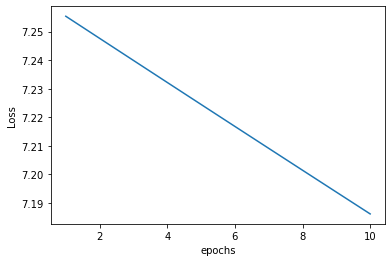

Train accuracy,0.115
_runtime,7
_timestamp,1615544381
_step,1
Test accuracy,0.1


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 86zg0809 with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Linear
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Softmax


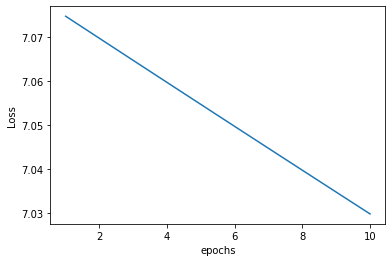

Train accuracy,0.109
_runtime,7
_timestamp,1615544399
_step,1
Test accuracy,0.1112


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: blig6rr7 with config:
wandb: 	batch_size: 1
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax


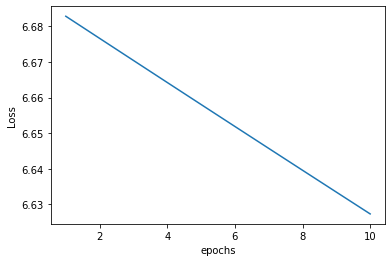

Train accuracy,0.115
_runtime,7
_timestamp,1615544417
_step,1
Test accuracy,0.1001


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: gldb9use with config:
wandb: 	batch_size: 1
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Linear


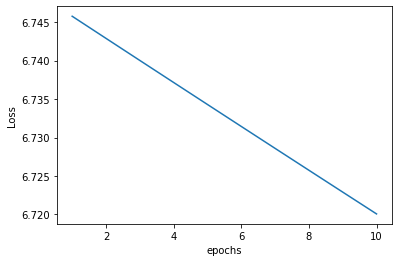

Train accuracy,0.083
_runtime,7
_timestamp,1615544435
_step,1
Test accuracy,0.0819


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 3cr5uaun with config:
wandb: 	batch_size: 1
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Linear


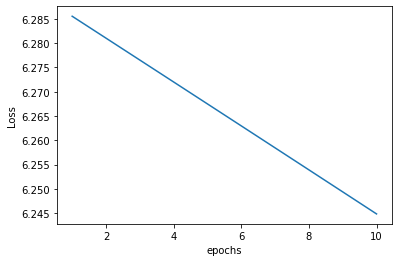

Train accuracy,0.115
_runtime,7
_timestamp,1615544455
_step,1
Test accuracy,0.1092


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: pqhx175v with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Linear


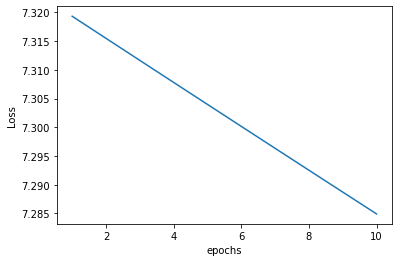

Train accuracy,0.092
_runtime,7
_timestamp,1615544473
_step,1
Test accuracy,0.0974


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: w8fg1bjw with config:
wandb: 	batch_size: 1
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Softmax


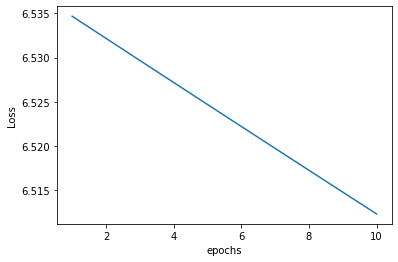

Train accuracy,0.101
_runtime,6
_timestamp,1615544491
_step,1
Test accuracy,0.1119


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: bsts65yn with config:
wandb: 	batch_size: 1
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Linear
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Softmax


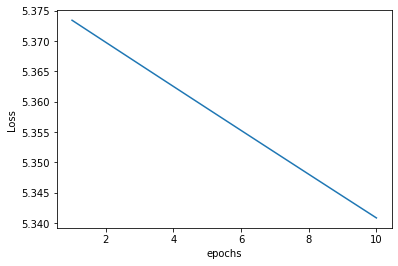

Train accuracy,0.143
_runtime,7
_timestamp,1615544510
_step,1
Test accuracy,0.141


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: fpo45xmz with config:
wandb: 	batch_size: 1
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Linear


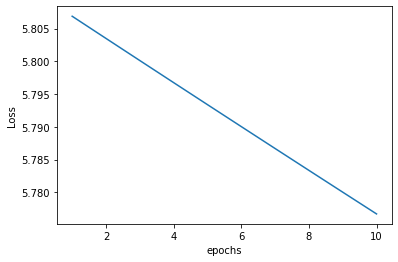

Train accuracy,0.099
_runtime,6
_timestamp,1615544527
_step,1
Test accuracy,0.1127


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: s2bjqum1 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax


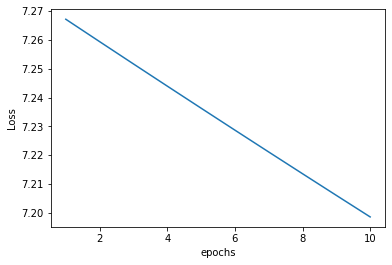

Train accuracy,0.098
_runtime,7
_timestamp,1615544545
_step,1
Test accuracy,0.104


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: w1av24v0 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Tanh
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Linear


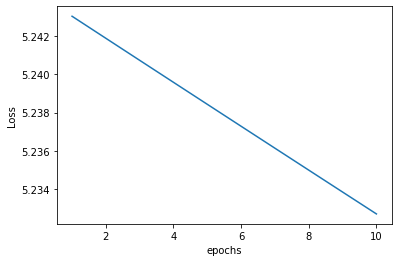

Train accuracy,0.067
_runtime,6
_timestamp,1615544564
_step,1
Test accuracy,0.0653


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: dfff69h2 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Linear


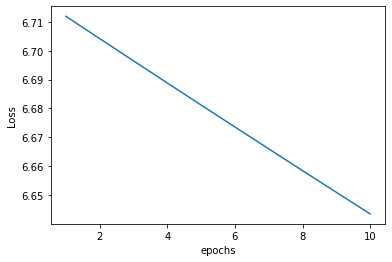

Train accuracy,0.102
_runtime,7
_timestamp,1615544584
_step,1
Test accuracy,0.1038


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: bbmqytsj with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Tanh
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Linear


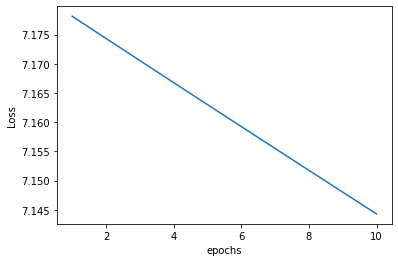

Train accuracy,0.065
_runtime,7
_timestamp,1615544602
_step,1
Test accuracy,0.0605


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: haoxnz90 with config:
wandb: 	batch_size: 1
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Softmax


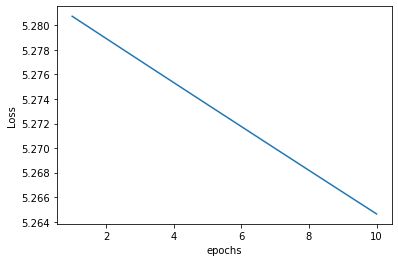

Train accuracy,0.091
_runtime,7
_timestamp,1615544621
_step,1
Test accuracy,0.0867


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 3amewgj5 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Softmax


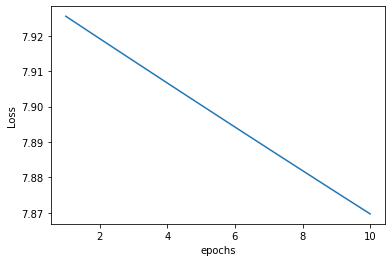

Train accuracy,0.095
_runtime,7
_timestamp,1615544640
_step,1
Test accuracy,0.0996


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: h0gja8h0 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Tanh
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax


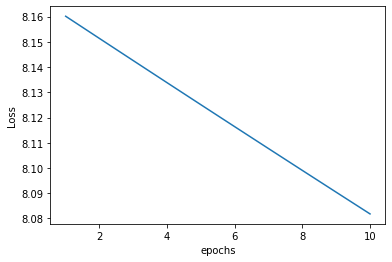

Train accuracy,0.108
_runtime,7
_timestamp,1615544658
_step,1
Test accuracy,0.094


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: y7tdh862 with config:
wandb: 	batch_size: 1
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Linear


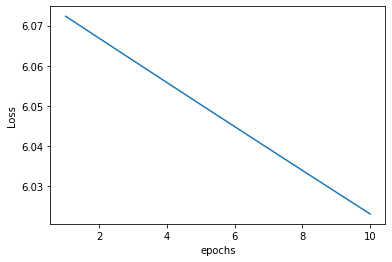

Train accuracy,0.095
_runtime,7
_timestamp,1615544677
_step,1
Test accuracy,0.1003


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: s74p2onh with config:
wandb: 	batch_size: 1
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Softmax


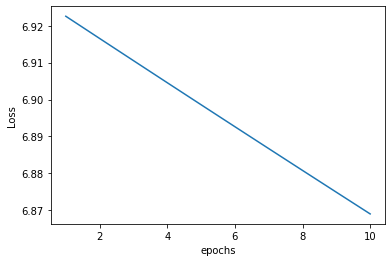

Train accuracy,0.099
_runtime,6
_timestamp,1615544695
_step,1
Test accuracy,0.0975


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: ec4p4mh4 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Linear


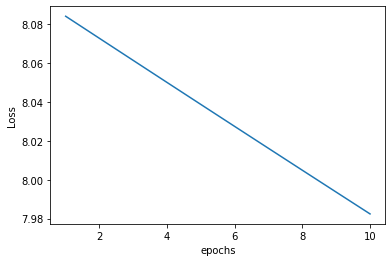

Train accuracy,0.101
_runtime,6
_timestamp,1615544713
_step,1
Test accuracy,0.1031


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hrcfg071 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Linear


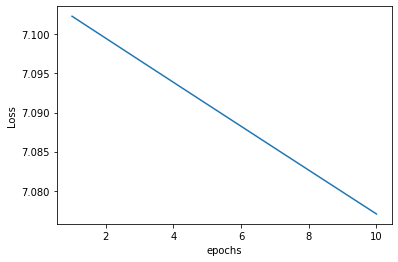

Train accuracy,0.104
_runtime,7
_timestamp,1615544739
_step,1
Test accuracy,0.0971


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: gwqyej8u with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Softmax


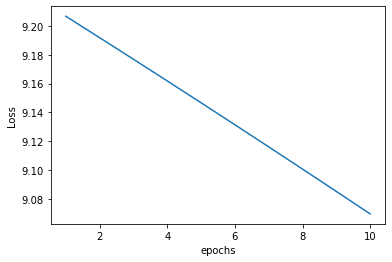

Train accuracy,0.099
_runtime,7
_timestamp,1615544757
_step,1
Test accuracy,0.1001


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: pj7plkot with config:
wandb: 	batch_size: 1
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Softmax


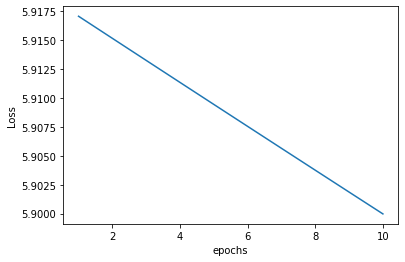

Train accuracy,0.099
_runtime,6
_timestamp,1615544776
_step,1
Test accuracy,0.1155


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: i8an7nth with config:
wandb: 	batch_size: 1
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax


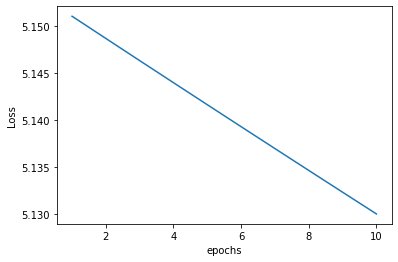

Train accuracy,0.118
_runtime,7
_timestamp,1615544795
_step,1
Test accuracy,0.1133


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: wkgue322 with config:
wandb: 	batch_size: 1
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Tanh
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Linear


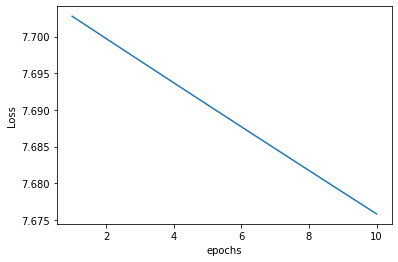

Train accuracy,0.099
_runtime,6
_timestamp,1615544813
_step,1
Test accuracy,0.103


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: z1vzplld with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Linear


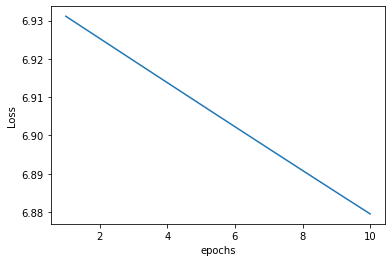

Train accuracy,0.119
_runtime,6
_timestamp,1615544831
_step,1
Test accuracy,0.1135


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: eu3698za with config:
wandb: 	batch_size: 1
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Linear


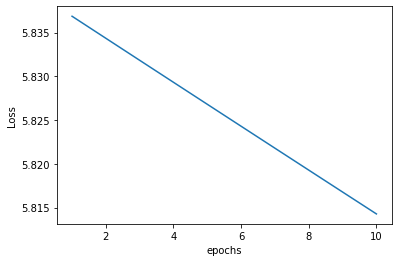

Train accuracy,0.077
_runtime,7
_timestamp,1615544850
_step,1
Test accuracy,0.0851


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: byy5zyxb with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Tanh
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax


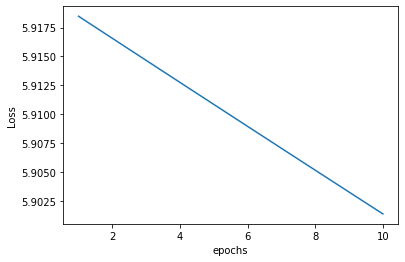

Train accuracy,0.031
_runtime,7
_timestamp,1615544868
_step,1
Test accuracy,0.0372


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: wsltx8x9 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Softmax


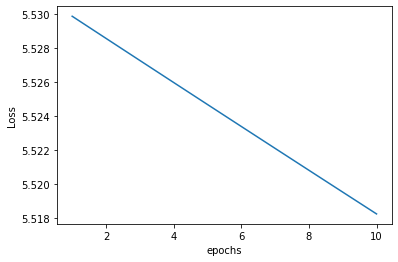

Train accuracy,0.098
_runtime,6
_timestamp,1615544886
_step,1
Test accuracy,0.1102


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: k3wr9gr7 with config:
wandb: 	batch_size: 1
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Softmax


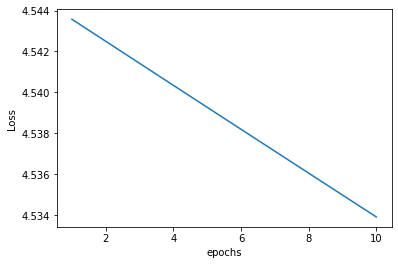

Train accuracy,0.082
_runtime,7
_timestamp,1615544905
_step,1
Test accuracy,0.0817


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: uxpvf42s with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Tanh
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Linear


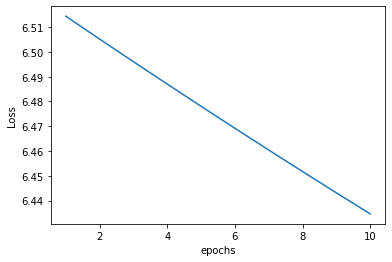

Train accuracy,0.099
_runtime,6
_timestamp,1615544923
_step,1
Test accuracy,0.0906


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 4oo3belv with config:
wandb: 	batch_size: 1
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Softmax


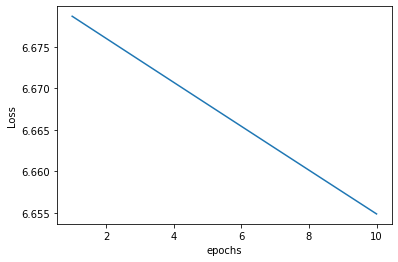

Train accuracy,0.084
_runtime,6
_timestamp,1615544941
_step,1
Test accuracy,0.0867


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: hmawvv07 with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Softmax


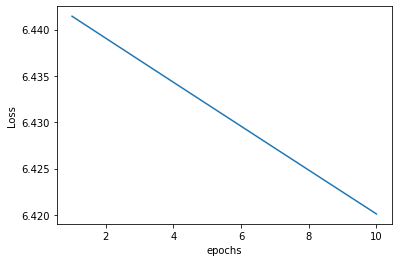

Train accuracy,0.098
_runtime,6
_timestamp,1615544959
_step,1
Test accuracy,0.0928


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: blbzhqwn with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Linear
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Softmax


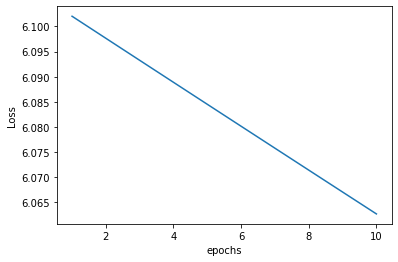

Train accuracy,0.108
_runtime,7
_timestamp,1615544977
_step,1
Test accuracy,0.1027


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: ntkys23p with config:
wandb: 	batch_size: 1000
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Linear
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Linear


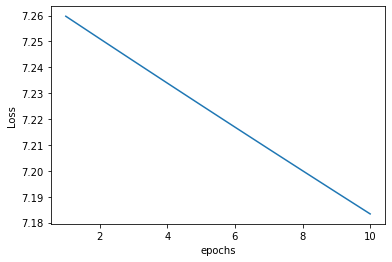

Train accuracy,0.096
_runtime,6
_timestamp,1615544995
_step,1
Test accuracy,0.1031


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/internal/internal_api.py", line 1313, in agent_heartbeat
    timeout=60,
  File "/usr/local/lib/python3.7/dist-packages/wandb/old/retry.py", line 96, in __call__
    result = self._call_fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/internal/internal_api.py", line 123, in execute
    return self.client.execute(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/client.py", line 52, in execute
    result = self._get_result(document, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/client.py", line 60, in _get_result
    return self.transport.execute(document, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/transport/requests.py", line 38, in execute
    request = requests.post(self.url, **post_args)
  File "/usr/loc

In [ ]:
def train():
  run = wandb.init()
  X_sample=X_train[:1000]
  Y_sample_ohe=Y_train_ohe[:1000]

  NN1 = NN(input_shape=784,num_hlayers=2,neurons=[32,16],hiddenLayerActivation='Sigmoid',outputActivation='Softmax',optimizer='Nestrov',\
           learningrate=1e-3,batch_size=1,epochs=10,layerInitialization='Random',output_shape=10)

  pred , loss=MINI_BATCH(NN1,X_sample,Y_sample_ohe)
  
  wandb.log({"Train accuracy": np.sum(np.argmax(pred,axis=1)==np.argmax(Y_sample_ohe,axis=1))/len(Y_sample_ohe)})

  plt.plot(np.arange(1,(NN1.epochs)+1),loss)
  plt.xlabel("epochs");plt.ylabel("Loss");plt.show()

  predtest=NN1.Final_Prediction(X_test)
  
  wandb.log({"Test accuracy": np.sum(np.argmax(predtest,axis=1)==np.argmax(Y_test_ohe,axis=1))/len(Y_test_ohe)})

wandb.agent(sweep_id, function=train)